In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.special import rel_entr

In [2]:
def DKL(A, B):
    """
    Kulback-Leibler divergence D(A||B)
    :param A: pa(x), target distribution
    :param B: pb(x), other distribution
    :return: component-wise DKL(pa(x) || pb(x)), which is a tensor of the same dimensionality as A and B
    :        each entry in the tensor is Ai * ln(Ai / Bi), which means the i-th component of DKL.
    :        this code structure, to return the component-wise Dkl, rather than sum_i Ai*ln(Ai/Bi),
    :        simplifies the update equations and the calculation of MI. 
    :        you will use it in the calculation of mutual information and in the update equations of IB.
    """
    # your code
    d = np.where(A != 0, A * np.log(A / B), 0)

    d[np.isnan(d)] = 0 # 1e-64
    d[np.isinf(d)] = 0 # 1e-64
   
    return d


In [3]:
def I(pA, pB, pAB):
    """mutual information I(X,Y) = DKL(P(x,y) || Px x Py)
    :param pA: A - p(a): marginal probability of X
    :param pB: B - p(b): marginal probability of Y
    :param pAB: p(a,b): joint probability of X and Y"""

    
    # your code (use your DKL function above)
    X = np.sum(DKL(pAB, pA*pB))

    return X

In [4]:
def entropy(p):
    """entropy of a discrete distribution"""
    ### example for the vectorized calculation of the entropy ###
    return -np.sum(p * np.log(p))


In [5]:
def make_probs(*dims):
    XY = np.random.rand(*dims)
    # normalize to a probability
    XY = XY / XY.sum()
    return XY

In [6]:
def iterative_information_bottleneck(
        Xdim, Ydim, Mmax, Mmin,
        n_iters=100, # iteration of the equations until convergence
        n_tries=3  , # number of trials from random initial conditions with n_iters e.o.
        n_betas=100, # number of different beta values to create the IB curve
        beta_min=0.1,#   the above results in 30000 itertions
        beta_max=100):

    # working with probabilities as tensors makes it easier to
    # read/write code and lets us utilize numpy broadcasting.
    # e.g, in this function we are working with discrete random
    # variables X, Y, and T. We can represent all probabilities as
    # tensors, where each dimension represents a random variable.

    # e.g. p(x,y) is a tensor of shape (Xdim, Ydim, 1)
    pXY = make_probs(Xdim, Ydim, 1)
    # p(x) is a tensor of shape (Xdim, 1, 1)
    pX = np.sum(pXY, axis = 1)[:,:,np.newaxis]
    # p(y) is a tensor of shape (1, Ydim, 1)
    pY = np.sum(pXY, axis = 0)[np.newaxis,:,:]
    
    # p(y | x) is a tensor of shape (Xdim, Ydim, 1), calculate it from pXY and Px
    pY_X =  np.divide(pXY, pX)
    
    hX = entropy(pX)
    hY = entropy(pY)
    
    target_MI = I(pX, pY, pXY)
    print("The MI between generated X and Y is:", target_MI)
    print("The entropy of X is:", hX)
    print("The entropy of Y is:", hY)

  
    # Lagrangian
    Ls = np.zeros((Mmax - Mmin+1, n_betas))
    
    # relevance I(T;Y)
    I_TYs = np.zeros((Mmax - Mmin+1, n_betas))
    
    # compression I(T;X)
    I_TXs = np.zeros((Mmax - Mmin+1, n_betas))
    
    # betas
    betas = np.zeros((Mmax - Mmin+1, n_betas))
    # change the cardinality of the features, starting from |T| == |X|m and decreasing by steps on 2
    for m, M in enumerate(range(Mmax, Mmin-1, -2)):
        for i, beta in enumerate(np.linspace(beta_min, beta_max, n_betas)[::-1]):

            L = np.inf
            I_TX = np.nan
            I_TY = np.nan
            for _ in range(0, n_tries):
                
                # initialize random p(t, x)
                pTX = make_probs(Xdim, 1, M)
                
                # normalize it to a conditional probablity for T given X
                pT_X = pTX/np.sum(pTX, axis = 2)[:,:,np.newaxis]
                # compute pT according to the Bayes rule from pT and pT_X
                pT = np.sum(pT_X*np.sum(pTX, axis = 2)[:,:,np.newaxis], axis = 0)[np.newaxis,:,:]
                # compute using broadcasting p(y | t) = sum_ x pY_X * pX_T = sum_x pY_X * (pT_X * pX/ pT)
                pY_T = np.sum(pXY*(pT_X/pT), axis = 0)[np.newaxis,:,:]
                # the problem is not convex, so we try a few times and take the best solution
                for _ in range(0, n_iters):  
                    ############# a single IB update
                    # write your code for: pT_X 
                    dkl = DKL(pY_X, pY_T)
                    pT_X=pT*np.exp(beta * dkl)/np.sum(np.sum(pT*np.exp(beta * dkl), axis = 0), axis=0)

                    # write your code for: pT 
                    pT = np.sum(pT_X*pX, axis = 0)[np.newaxis,:,:]
        
                    # write your code for: pY_T 
                    pY_T = np.sum(pXY*(pT_X/pT), axis = 0)[np.newaxis,:,:]

                    I_TX_ = I(pT, pX, pT_X * pX)/2 # calculate I[T; X]
  
                    I_TY_ = I(pT, pY, pY_T * pT)/2 # calculate I[T; Y]

                    L_ = I_TX_ - I_TY_ * beta    # calculate the objective of IB
#                     print(L_, L)
                    if L_ < L: # find find the minimum within n_iters. we need it because the problem is not convex
                        L = L_
                        I_TX = I_TX_
                        I_TY = I_TY_
            # save minimum L, corresponding beta, and mutual information tx and ty
            Ls[m, i] = L
            I_TXs[m, i] = I_TX
            I_TYs[m, i] = I_TY
            betas[m, i] = beta

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # relevance-compression curves
    axs[0].set_title("Lagrangian Temperature Relevance-Compression Curves")
    axs[0].set_xlabel("I(T;X)/H(X)")
    axs[0].set_ylabel("I(T;Y)/I(Y;X)")
    for i, (itx, ity, ls) in enumerate(zip(I_TXs, I_TYs, Ls)):
        axs[0].scatter(itx / hX, ity / target_MI, label=f"M:{Mmax - i}", s=5, c=ls, cmap="plasma")

    axs[1].set_title("Beta Temperature Relevance-Compression Curves")
    axs[1].set_xlabel("I(T;X)/H(X)")
    axs[1].set_ylabel("I(T;Y)/I(Y;X)")
    for i, (itx, ity, bs) in enumerate(zip(I_TXs, I_TYs, betas)):
        axs[1].scatter(itx / hX, ity / target_MI, label=f"M:{Mmax - i}", s=5, c=bs, cmap="RdYlBu_r")

    axs[2].set_title("Relevance-Compression Curves")
    axs[2].set_xlabel("I(T;X)/H(X)")
    axs[2].set_ylabel("I(T;Y)/I(Y;X)")
    for i, (itx, ity) in enumerate(zip(I_TXs, I_TYs)):
        axs[2].scatter(itx / hX, ity / target_MI, label=f"M:{Mmax - i}", s=5)
    axs[2].legend()

    fig.tight_layout()
    plt.show()

The MI between generated X and Y is: 0.0865723371381125
The entropy of X is: 2.2751196924778148
The entropy of Y is: 1.5967386093690563


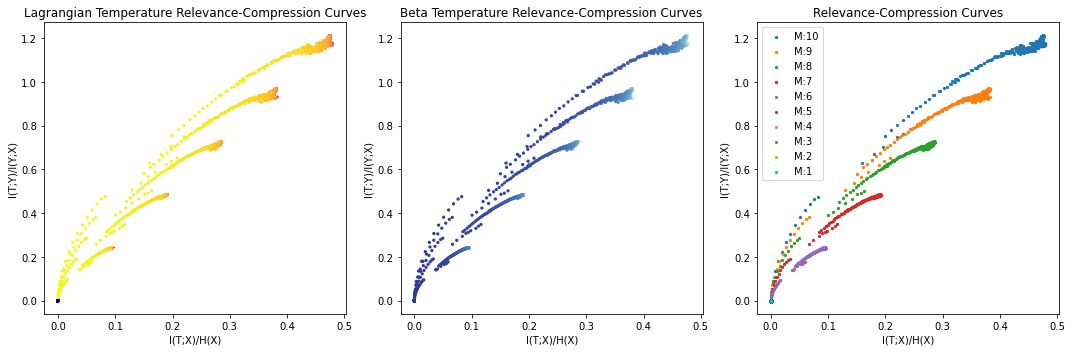

In [7]:
if __name__ == '__main__':
    iterative_information_bottleneck(
        Xdim=10,
        Ydim=5,
        Mmax=10, # the same cardinality as in the original X
        Mmin=1, # everything is collapsed to a single cluster
        n_iters=100,
        n_tries=100,
        n_betas=1000,
        beta_min=0.1,
        beta_max=1000
    )